In [1]:

from datasets import load_dataset,Dataset,DatasetDict
import pandas as pd
import random
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from huggingface_hub import login
from dotenv import load_dotenv
import numpy as np # Make sure numpy is imported for np.ceil and np.nan
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for statistical plots

load_dotenv()

# Set a professional and readable plot style
sns.set_theme(style="whitegrid")

In [2]:
dataset = load_dataset("Vishva007/RBI-Circular-QA-Dataset")

df = dataset['train'].to_pandas() 

# --- Define the target size for your balanced eval set ---
TARGET_EVAL_SIZE = 1000


In [3]:

# --- Map numerical difficulty to categorical labels for the full training dataframe (df) ---
# This step is crucial for stratifying by 'estimated_difficulty_mapped'
print("\nMapping numerical difficulty to categorical labels for the full training data (for stratification)...")
def map_difficulty(difficulty_score):
    if pd.isna(difficulty_score):
        return np.nan
    if difficulty_score in [1, 2]:
        return 'easy'
    elif difficulty_score in [3, 4, 5]:
        return 'medium'
    elif difficulty_score in [6, 7]:
        return 'hard'
    else:
        return 'unknown' # For any unexpected scores

df['estimated_difficulty_mapped'] = df['estimated_difficulty'].apply(map_difficulty)
print("Difficulty mapping complete on full training data.")



Mapping numerical difficulty to categorical labels for the full training data (for stratification)...
Difficulty mapping complete on full training data.


In [4]:

# --- Strategy for Balanced Sampling ---
# We'll stratify by multiple features if possible.
# A common strategy is to combine categories into a single 'stratification_key'.
# If a direct multi-column stratification is too complex or results in too many tiny groups,
# you can prioritize the most important feature (e.g., 'estimated_difficulty_mapped').

# Let's create a combined stratification key
df['stratification_key'] = df['regulation_area'].astype(str) + "_" + \
                          df['applicable_to'].astype(str) + "_" + \
                          df['category'].astype(str) + "_" + \
                          df['estimated_difficulty_mapped'].astype(str)

print(f"\nAttempting to create a balanced evaluation set of {TARGET_EVAL_SIZE} samples using stratified sampling...")



Attempting to create a balanced evaluation set of 1000 samples using stratified sampling...


In [5]:

# Calculate target samples per group
group_counts = df['stratification_key'].value_counts()
total_groups = len(group_counts)

# Define a minimum number of samples per group, or a minimum percentage
min_samples_per_group = 1 

eval_split_list = []
# Iterate through each unique stratification key and sample proportionally
for key in group_counts.index:
    group_df = df[df['stratification_key'] == key]
    
    # Calculate target number of samples for this group
    num_samples_for_group = int(np.ceil((group_counts[key] / len(df)) * TARGET_EVAL_SIZE))
    
    # Ensure we don't try to sample more than available
    num_samples_for_group = min(num_samples_for_group, len(group_df))

    if num_samples_for_group > 0:
        sampled_group = group_df.sample(n=num_samples_for_group, random_state=42)
        eval_split_list.append(sampled_group)
    else:
        print(f"Skipping group '{key}': not enough samples for proportionate representation.")

if eval_split_list:
    eval_split_df = pd.concat(eval_split_list).reset_index(drop=True)
    if len(eval_split_df) > TARGET_EVAL_SIZE:
        eval_split_df = eval_split_df.sample(n=TARGET_EVAL_SIZE, random_state=42).reset_index(drop=True)
else:
    print("Warning: No samples selected for evaluation. Check stratification logic or dataset.")
    eval_split_df = pd.DataFrame() 

# Drop the temporary stratification key column before proceeding
if 'stratification_key' in eval_split_df.columns:
    eval_split_df = eval_split_df.drop(columns=['stratification_key'])
if 'stratification_key' in df.columns:
    df = df.drop(columns=['stratification_key'])

print(f"Shape of the balanced evaluation split: {eval_split_df.shape}")
print("\nDistribution of categories in Balanced Eval Split (Estimated Difficulty Mapped):")
print(eval_split_df['estimated_difficulty_mapped'].value_counts(normalize=True))
print("\nDistribution of categories in Balanced Eval Split (Regulation Area):")
print(eval_split_df['regulation_area'].value_counts(normalize=True))


Shape of the balanced evaluation split: (1000, 17)

Distribution of categories in Balanced Eval Split (Estimated Difficulty Mapped):
estimated_difficulty_mapped
medium    0.876
easy      0.078
hard      0.046
Name: proportion, dtype: float64

Distribution of categories in Balanced Eval Split (Regulation Area):
regulation_area
Basel III Capital Regulations      0.154
Banking Regulation                 0.102
Prudential Norms                   0.060
Foreign Exchange Management        0.059
Anti-Money Laundering              0.054
                                   ...  
Fair Practices Code for Lenders    0.001
Foreign Exchange                   0.001
Data Reporting                     0.001
Risk Management                    0.001
MSME Lending                       0.001
Name: proportion, Length: 101, dtype: float64



--- EDA for Balanced Eval Split Categorical Features ---

Analyzing distribution of 'regulation_area' in Balanced Eval Split:


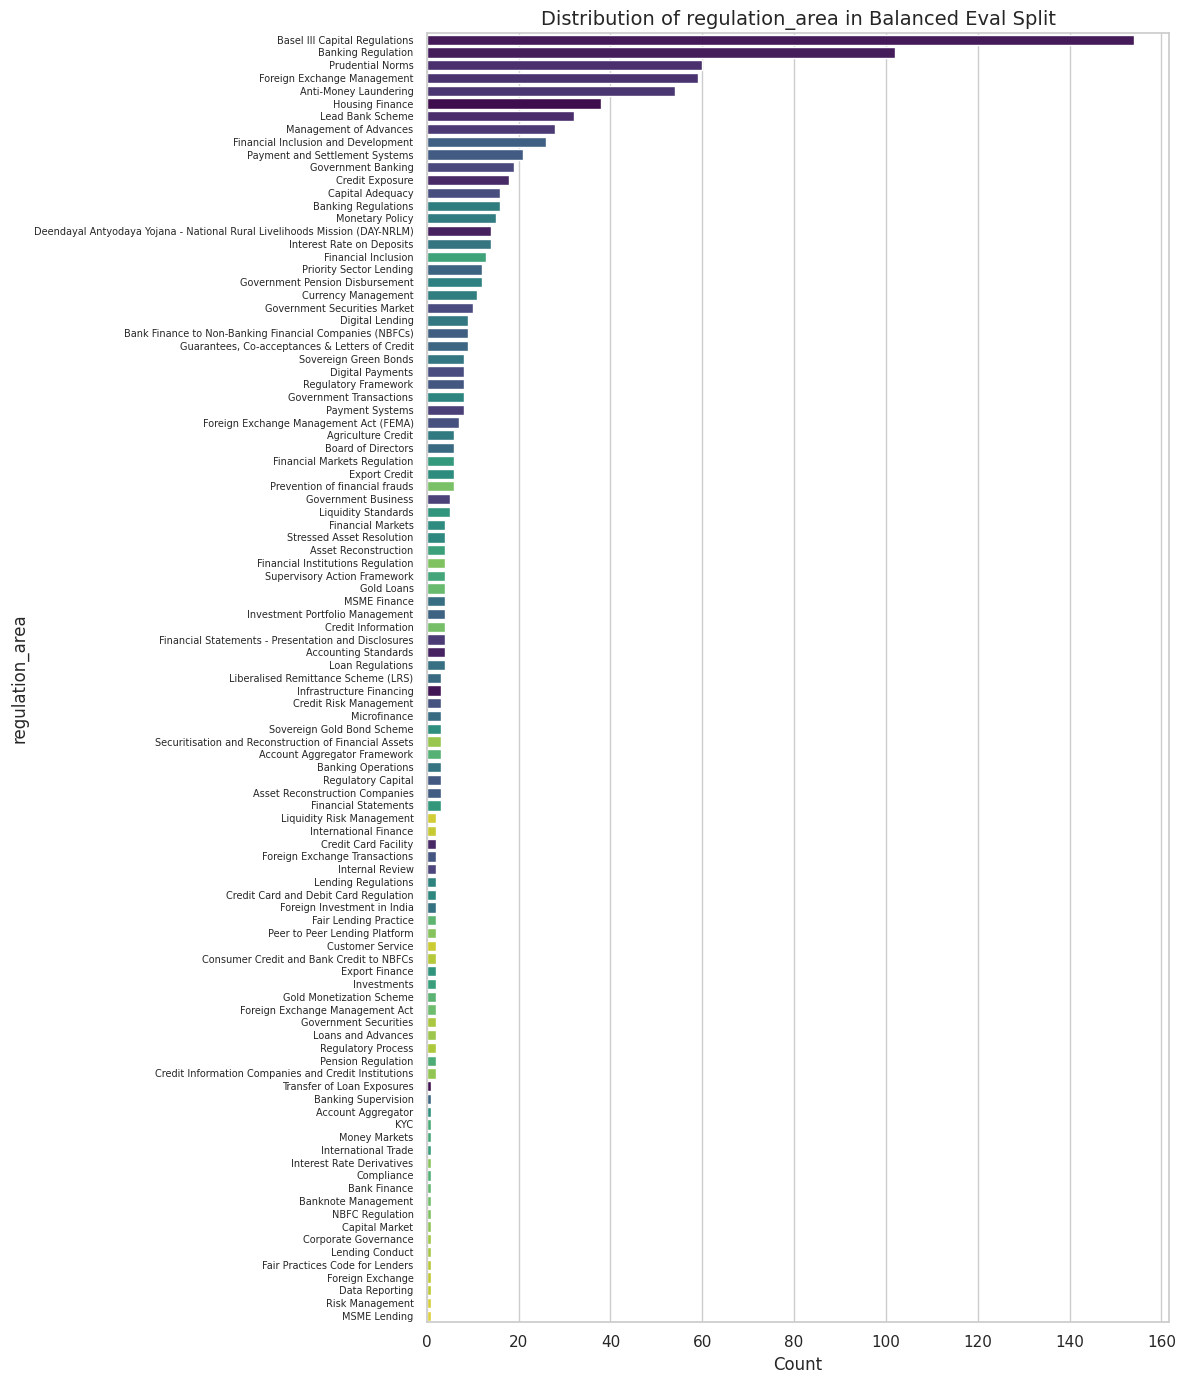

Value counts (normalized) for 'regulation_area':
regulation_area
Basel III Capital Regulations      0.154
Banking Regulation                 0.102
Prudential Norms                   0.060
Foreign Exchange Management        0.059
Anti-Money Laundering              0.054
                                   ...  
Fair Practices Code for Lenders    0.001
Foreign Exchange                   0.001
Data Reporting                     0.001
Risk Management                    0.001
MSME Lending                       0.001
Name: proportion, Length: 101, dtype: float64

Analyzing distribution of 'applicable_to' in Balanced Eval Split:


/tmp/ipykernel_909/958729312.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


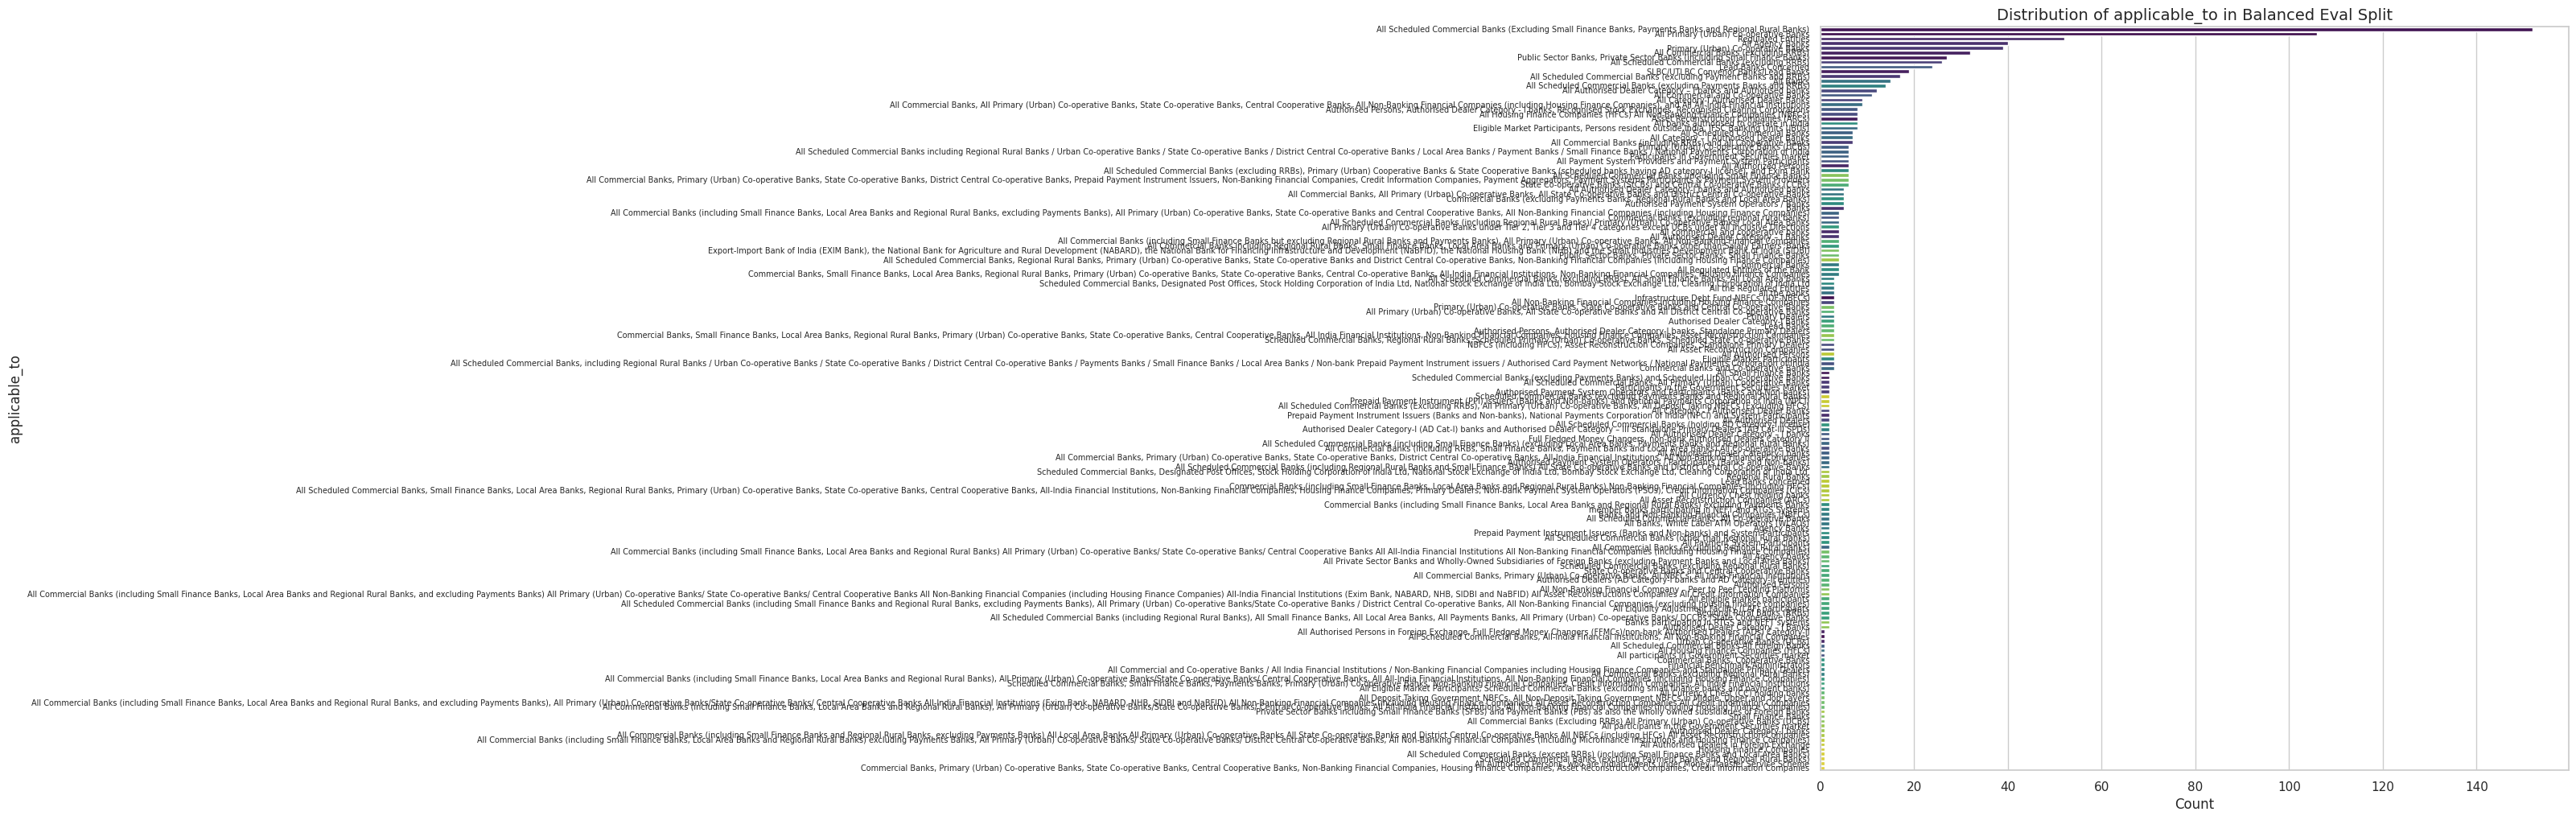

Value counts (normalized) for 'applicable_to':
applicable_to
All Scheduled Commercial Banks (Excluding Small Finance Banks, Payments Banks and Regional Rural Banks)                                                                                                                                0.152
All Primary (Urban) Co-operative Banks                                                                                                                                                                                                 0.106
Regulated Entities                                                                                                                                                                                                                     0.052
All Agency Banks                                                                                                                                                                                                                    

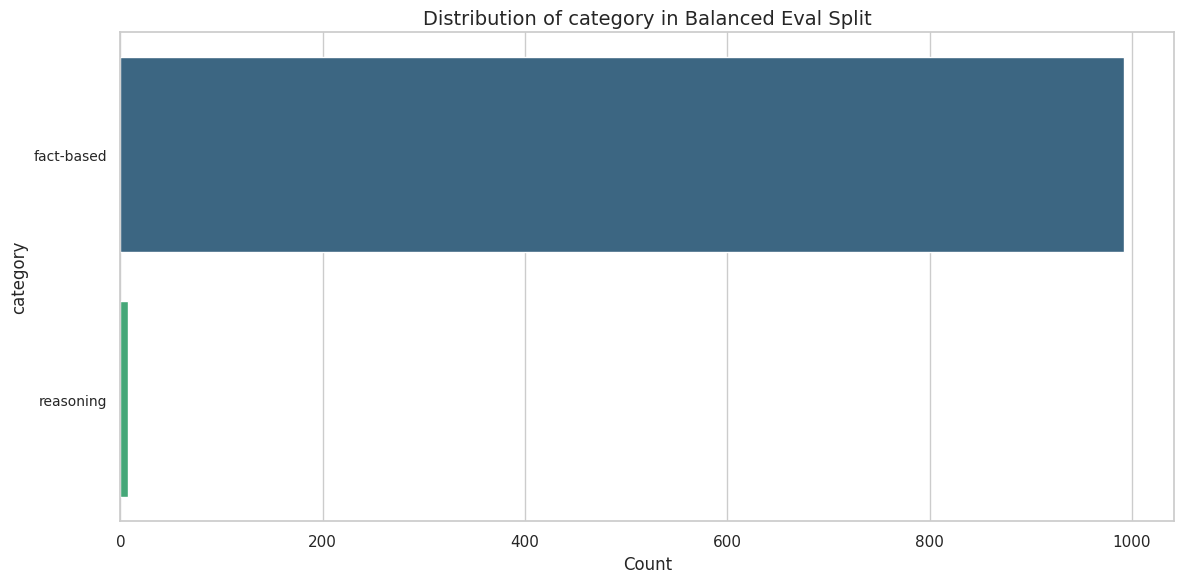

Value counts (normalized) for 'category':
category
fact-based    0.992
reasoning     0.008
Name: proportion, dtype: float64

Analyzing distribution of 'estimated_difficulty_mapped' in Balanced Eval Split:


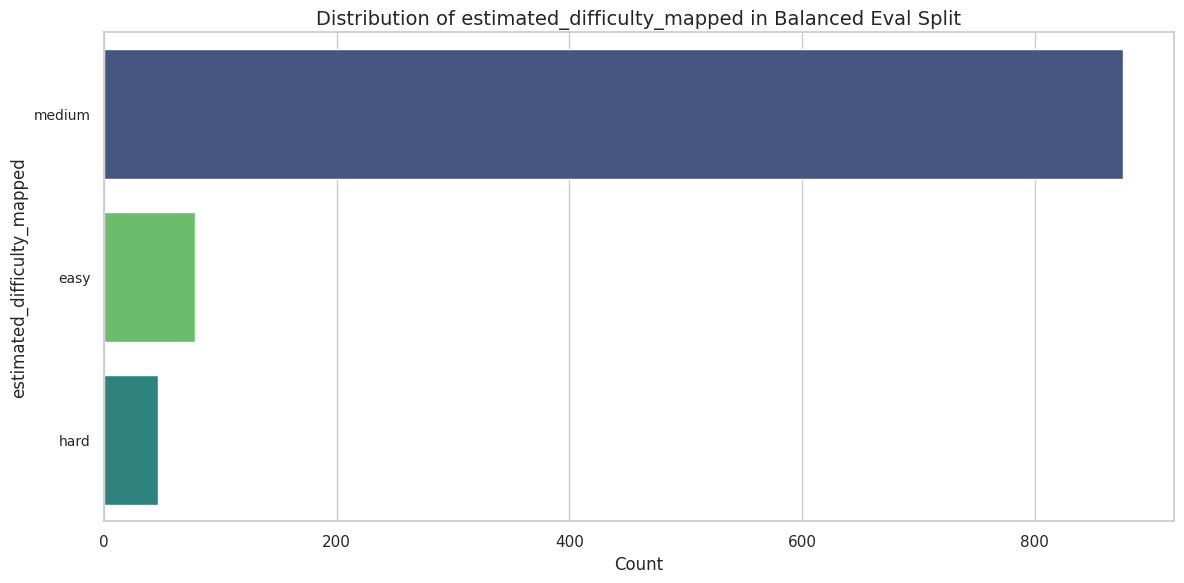

Value counts (normalized) for 'estimated_difficulty_mapped':
estimated_difficulty_mapped
medium    0.876
easy      0.078
hard      0.046
Name: proportion, dtype: float64

--- EDA for Balanced Eval Split Text Lengths ---

Analyzing distribution of 'question_len' in Balanced Eval Split:


/tmp/ipykernel_909/958729312.py:56: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(eval_split_df[feature], bins=30, kde=True, palette='viridis')


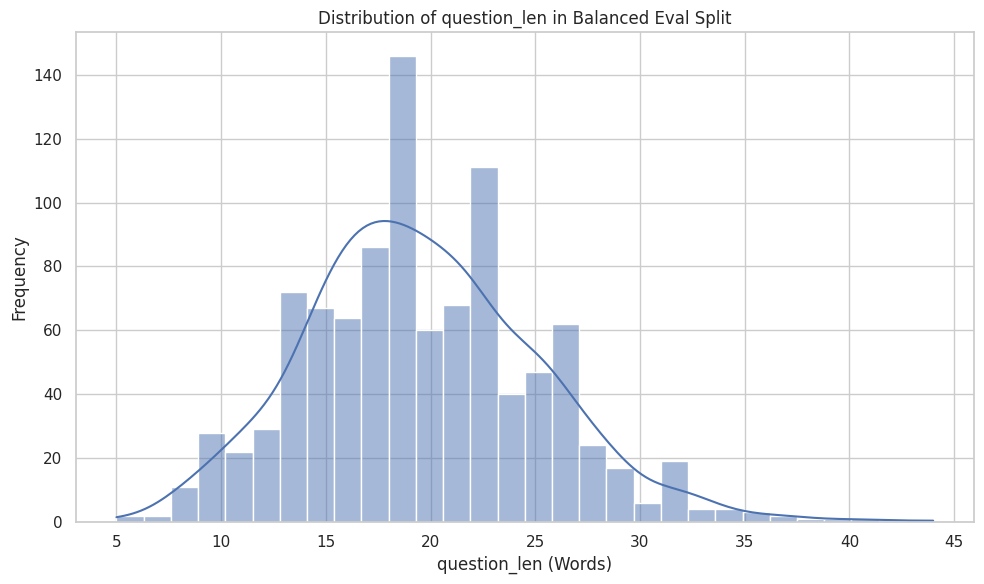

Descriptive statistics for 'question_len':
count    1000.000000
mean       19.600000
std         5.594936
min         5.000000
25%        16.000000
50%        19.000000
75%        23.000000
max        44.000000
Name: question_len, dtype: float64

Analyzing distribution of 'answer_len' in Balanced Eval Split:


/tmp/ipykernel_909/958729312.py:56: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(eval_split_df[feature], bins=30, kde=True, palette='viridis')


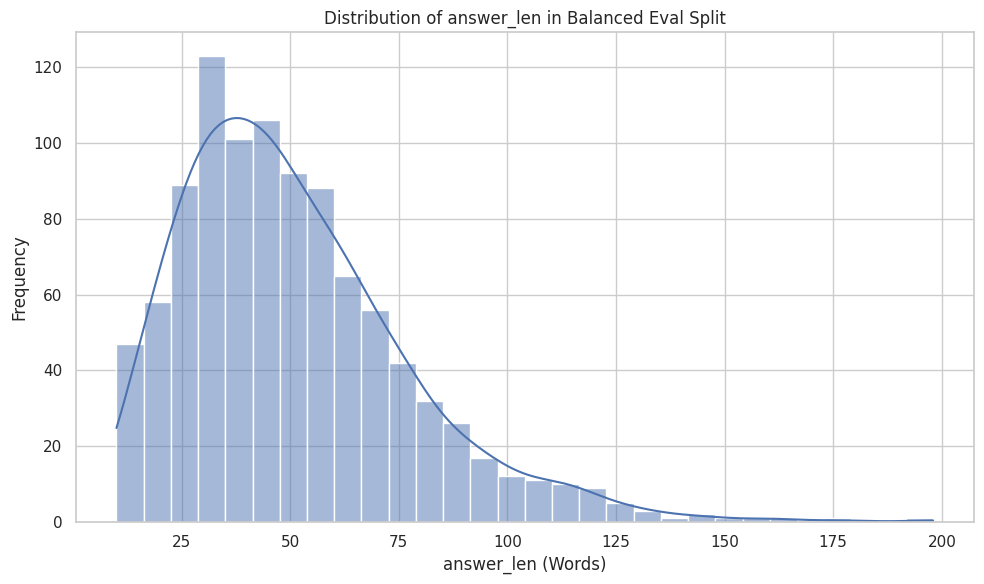

Descriptive statistics for 'answer_len':
count    1000.000000
mean       50.852000
std        26.308825
min        10.000000
25%        32.000000
50%        46.000000
75%        64.000000
max       198.000000
Name: answer_len, dtype: float64

Analyzing distribution of 'chunk_len' in Balanced Eval Split:


/tmp/ipykernel_909/958729312.py:56: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(eval_split_df[feature], bins=30, kde=True, palette='viridis')


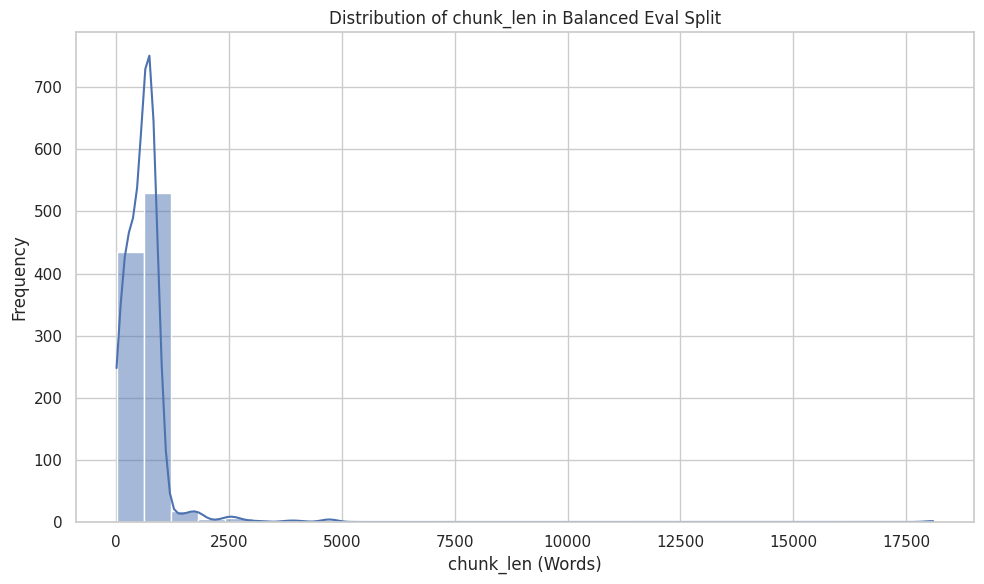

Descriptive statistics for 'chunk_len':
count     1000.000000
mean       611.107000
std        711.157479
min         11.000000
25%        295.000000
50%        671.000000
75%        765.000000
max      18097.000000
Name: chunk_len, dtype: float64

EDA of the balanced eval dataset complete. Review these plots to ensure your stratification was effective.
Proceeding with rephrasing and dataset update...


In [6]:


# --- EDA for the newly created Balanced Eval Split ---
print("\n--- EDA for Balanced Eval Split Categorical Features ---")
# Define the features we want to plot
eval_categorical_features = ['regulation_area', 'applicable_to', 'category', 'estimated_difficulty_mapped']

for feature in eval_categorical_features:
    if feature in eval_split_df.columns:
        print(f"\nAnalyzing distribution of '{feature}' in Balanced Eval Split:")
        
        # Calculate value counts and sort for consistent plotting
        feature_counts = eval_split_df[feature].value_counts()
        
        # Determine optimal figure height based on number of unique categories
        num_categories = feature_counts.nunique()
        base_height_per_category = 0.5 
        dynamic_height = max(6, num_categories * base_height_per_category)
        dynamic_height = min(dynamic_height, 30) # Cap max height to avoid excessively large plots

        plt.figure(figsize=(12, dynamic_height))
        sns.countplot(data=eval_split_df, y=feature, order=feature_counts.index, hue=feature, palette='viridis', legend=False)
        plt.title(f'Distribution of {feature} in Balanced Eval Split', fontsize=14)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(feature, fontsize=12)

        # Adjust y-axis label font size for readability if many categories
        if num_categories > 20: 
            plt.tick_params(axis='y', labelsize=7) 
        elif num_categories > 10: 
            plt.tick_params(axis='y', labelsize=9)
        else: 
            plt.tick_params(axis='y', labelsize=10) 
            
        plt.tight_layout()
        plt.show()

        print(f"Value counts (normalized) for '{feature}':")
        print(eval_split_df[feature].value_counts(normalize=True))
    else:
        print(f"'{feature}' column not found in eval_split_df. Skipping plot.")

print("\n--- EDA for Balanced Eval Split Text Lengths ---")
# Pre-calculate lengths for the eval_split_df for plotting
eval_split_df['question_len'] = eval_split_df['question'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
eval_split_df['answer_len'] = eval_split_df['answer'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
# Note: rephrased_question_len and rephrased_answer_len will be calculated later, after rephrasing.
# We are plotting here *before* rephrasing, so we can only use 'question_len' and 'answer_len'.
eval_split_df['chunk_len'] = eval_split_df['chunks_text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)


length_features_for_initial_eval = ['question_len', 'answer_len', 'chunk_len']

for feature in length_features_for_initial_eval:
    if feature in eval_split_df.columns:
        print(f"\nAnalyzing distribution of '{feature}' in Balanced Eval Split:")
        plt.figure(figsize=(10, 6))
        sns.histplot(eval_split_df[feature], bins=30, kde=True, palette='viridis')
        plt.title(f'Distribution of {feature} in Balanced Eval Split')
        plt.xlabel(f'{feature} (Words)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        print(f"Descriptive statistics for '{feature}':")
        print(eval_split_df[feature].describe())
    else:
        print(f"'{feature}' column not found in eval_split_df. Skipping plot.")

print("\nEDA of the balanced eval dataset complete. Review these plots to ensure your stratification was effective.")
print("Proceeding with rephrasing and dataset update...")


In [7]:

class RephrasedContent(BaseModel):
    rephrased_question: str = Field(description="The rephrased version of the original question, tailored for book content.")
    rephrased_answer: str = Field(description="The rephrased version of the original answer, maintaining factual accuracy related to the book's content.")

In [8]:
RBI_Prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant specialized in rephrasing RBI financial questions and answers.
                 Your primary goal is to ensure that the rephrased question and answer are entirely **self-contained and context-independent**. This means they must be fully understandable to someone reading them in isolation, without any prior knowledge of the original document, conversation, or surrounding context.

                 Specifically:
                 1.  **Avoid vague referents:** Do not use pronouns or demonstratives (like "this," "that," "these," "those") if their antecedent is not explicitly defined within the rephrased text. For instance, instead of "this circular," try to incorporate the specific subject (e.g., "RBI's guidelines on...") or rephrase to remove the need for such a reference.
                 2.  **Include necessary specifics:** If a specific entity, regulation, document, or event is crucial to the meaning, ensure it's explicitly named or described in the rephrased text.
                 3.  **Retain full meaning and factual accuracy:** The rephrased content must precisely convey the same information as the original.

                 Rephrase the provided question to make it slightly different but retain its original meaning and ensure it's understandable on its own.
                 Also, rephrase the provided answer to make it slightly different while retaining its original meaning and factual accuracy, ensuring it is also self-contained."""),
    ("user", "Question: {question}\nAnswer: {answer}")
])

Book_Prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant specialized in rephrasing questions and answers from book content.
                 Rephrase the provided question to make it slightly different but retain its original meaning concerning the book's content.
                 Also, rephrase the provided answer to make it slightly different while retaining its original meaning and factual accuracy from the book."""),
    ("user", "Question: {question}\nAnswer: {answer}")
])

In [9]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                               temperature=0.7, 
                               google_api_key=os.environ.get("GEMINI_API_KEY"))


combined_rephrase_prompt = RBI_Prompt


combined_rephrase_chain = combined_rephrase_prompt | model.with_structured_output(RephrasedContent)


In [10]:


eval_split_df['rephrased_question'] = ""
eval_split_df['rephrased_answer'] = ""


# Iterate through the sampled DataFrame and rephrase
for index, row in eval_split_df.iterrows():
    original_question = row['question']
    original_answer = row['answer']

    try:
        rephrased_output = combined_rephrase_chain.invoke({
            "question": original_question,
            "answer": original_answer
        })
        
        eval_split_df.loc[index, 'rephrased_question'] = rephrased_output.rephrased_question # type: ignore
        eval_split_df.loc[index, 'rephrased_answer'] = rephrased_output.rephrased_answer # type: ignore # Corrected variable name here
        
        print(f"Processed sample {index+1}/{len(eval_split_df)}")
        
    except Exception as e:
        print(f"Error processing sample {index}: {e}")
        eval_split_df.loc[index, 'rephrased_question'] = f"Error: {e}"
        eval_split_df.loc[index, 'rephrased_answer'] = f"Error: {e}"


print("\nRephrasing complete. Displaying the first few rows of the rephrased evaluation split with all columns:")
print(eval_split_df.head())


Processed sample 1/1000
Processed sample 2/1000
Processed sample 3/1000
Processed sample 4/1000
Processed sample 5/1000
Processed sample 6/1000
Processed sample 7/1000
Processed sample 8/1000
Processed sample 9/1000
Processed sample 10/1000
Processed sample 11/1000
Processed sample 12/1000
Processed sample 13/1000
Processed sample 14/1000
Processed sample 15/1000
Processed sample 16/1000
Processed sample 17/1000
Processed sample 18/1000
Processed sample 19/1000
Processed sample 20/1000
Processed sample 21/1000
Processed sample 22/1000
Processed sample 23/1000
Processed sample 24/1000
Processed sample 25/1000
Processed sample 26/1000
Processed sample 27/1000
Processed sample 28/1000
Processed sample 29/1000
Processed sample 30/1000
Processed sample 31/1000
Processed sample 32/1000
Processed sample 33/1000
Processed sample 34/1000
Processed sample 35/1000
Processed sample 36/1000
Processed sample 37/1000
Processed sample 38/1000
Processed sample 39/1000
Processed sample 40/1000
Processed

In [11]:
print("Question")
print(eval_split_df['question'][0])
print("Rephrased Question")
print(eval_split_df['rephrased_question'][0])
print("Answer")
print(eval_split_df['answer'][0])
print("Rephrased Answer")
print(eval_split_df['rephrased_answer'][0]) 

Question
What considerations should Primary (Urban) Co-operative Banks take into account regarding penal charges for loan accounts?
Rephrased Question
What factors must Primary (Urban) Co-operative Banks consider when setting penal charges for loan accounts?
Answer
Primary (Urban) Co-operative Banks should establish clear and consistent policies regarding penal charges on loan accounts, ensuring they are applied fairly and transparently to all borrowers.
Rephrased Answer
For loan accounts, Primary (Urban) Co-operative Banks are required to create transparent and equitable policies regarding penal charges, which should be consistently applied to all borrowers.


In [12]:
# Before this line: new_eval_hf_dataset = Dataset.from_pandas(eval_split_df)

# List of columns to drop from eval_split_df if they are not desired in the final dataset
columns_to_drop_from_eval = [
    'estimated_difficulty_mapped',
    'question_len',
    'answer_len',
    'chunk_len'
    # 'rephrased_question_len', # You added this later, might want to drop it too
    # 'rephrased_answer_len'    # You added this later, might want to drop it too
]

# Ensure the columns exist before trying to drop them
columns_to_drop_existing = [col for col in columns_to_drop_from_eval if col in eval_split_df.columns]

if columns_to_drop_existing:
    eval_split_df = eval_split_df.drop(columns=columns_to_drop_existing)
    print(f"Dropped temporary columns from eval_split_df: {columns_to_drop_existing}")

# Now convert to Hugging Face Dataset
new_eval_hf_dataset = Dataset.from_pandas(eval_split_df)

Dropped temporary columns from eval_split_df: ['estimated_difficulty_mapped', 'question_len', 'answer_len', 'chunk_len']


In [13]:


# --- Step 4: Prepare the new 'eval' split and update the DatasetDict ---
print("\nStep 4: Preparing new 'eval' split and updating DatasetDict...")



original_train_hf_dataset = dataset['train']


new_columns_to_add = ['rephrased_question', 'rephrased_answer']
train_features = original_train_hf_dataset.features.keys()
columns_to_actually_add = [col for col in new_columns_to_add if col not in train_features]


if columns_to_actually_add:
    print(f"Adding missing columns {columns_to_actually_add} to the 'train' split for feature alignment...")
    original_train_hf_dataset = original_train_hf_dataset.map(
        lambda examples: {col: [""] * len(examples["question"]) for col in columns_to_actually_add},
        batched=True
    )
else:
    print("Train split already has 'rephrased_question' and 'rephrased_answer' columns.")


print("Features of 'train' split after alignment:")
print(original_train_hf_dataset.features)
print("\nFeatures of 'eval' split:")
print(new_eval_hf_dataset.features)



Step 4: Preparing new 'eval' split and updating DatasetDict...
Train split already has 'rephrased_question' and 'rephrased_answer' columns.
Features of 'train' split after alignment:
{'document': Value('string'), 'filename': Value('string'), 'model_name': Value('string'), 'regulation_area': Value('string'), 'applicable_to': Value('string'), 'issued_on': Value('string'), 'key_topics': List(Value('string')), 'chunks_text': Value('string'), 'is_table': Value('bool'), 'question': Value('string'), 'answer': Value('string'), 'evaluation_criteria': Value('string'), 'category': Value('string'), 'estimated_difficulty': Value('int64'), 'rephrased_question': Value('string'), 'rephrased_answer': Value('string')}

Features of 'eval' split:
{'document': Value('string'), 'filename': Value('string'), 'model_name': Value('string'), 'regulation_area': Value('string'), 'applicable_to': Value('string'), 'issued_on': Value('string'), 'key_topics': List(Value('string')), 'chunks_text': Value('string'), 'is

In [14]:


updated_dataset_dict = DatasetDict({
    'train': original_train_hf_dataset,
    'eval': new_eval_hf_dataset
})


In [15]:


print(f"Updated DatasetDict splits: {updated_dataset_dict.keys()}")
print(f"Number of samples in 'train' split: {len(updated_dataset_dict['train'])}")
print(f"Number of samples in 'eval' split: {len(updated_dataset_dict['eval'])}")


Updated DatasetDict splits: dict_keys(['train', 'eval'])
Number of samples in 'train' split: 12698
Number of samples in 'eval' split: 1000


In [16]:
login()

In [18]:


# --- Step 5: Push the updated DatasetDict to Hugging Face Hub ---
print("\nStep 5: Pushing the updated dataset to Hugging Face Hub...")
repo_id = "Vishva007/RBI-Circular-QA-Dataset" 


try:
    updated_dataset_dict.push_to_hub(repo_id, private=False)

    print(f"\nDataset '{repo_id}' successfully updated on Hugging Face Hub with 'eval' split!")
    print("You can view it here: https://huggingface.co/datasets/" + repo_id)

except Exception as e:
    print(f"\nError pushing to Hugging Face Hub: {e}")
    print("Please ensure you are logged in to Hugging Face Hub (`huggingface-cli login` or `notebook_login()`)")
    print(f"Also, verify you have write permissions for '{repo_id}' or choose a new `repo_id` under your namespace.")


Step 5: Pushing the updated dataset to Hugging Face Hub...


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md: 0.00B [00:00, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.



Dataset 'Vishva007/RBI-Circular-QA-Dataset' successfully updated on Hugging Face Hub with 'eval' split!
You can view it here: https://huggingface.co/datasets/Vishva007/RBI-Circular-QA-Dataset
